# Fake News Detection — Ready-to-Run Google Colab Notebook



In [1]:
# @title 0. Install & Imports (run first in Colab)
# If running locally, you can comment out the pip installs.
!pip install -q tensorflow nltk scikit-learn matplotlib seaborn

# Standard imports
import os
import re
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

# NLP & ML
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# NLTK downloads (first run)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

print('Environment ready. TensorFlow version:', tf.__version__)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Environment ready. TensorFlow version: 2.19.0


In [2]:
# @title 1. Load dataset
from google.colab import files
uploaded = files.upload()

# Load and preview
df = pd.read_csv("news.csv")
print('Dataset shape:', df.shape)
df.head()


Saving news.csv to news.csv
Dataset shape: (6335, 4)


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [3]:
# @title 2. Quick EDA & label detection
# Heuristically find text and label columns (works for common column names)
text_cols = [c for c in df.columns if c.lower() in ['text', 'article', 'content', 'body', 'headline', 'title']]
label_cols = [c for c in df.columns if c.lower() in ['label', 'class', 'target']]

TEXT_COL = text_cols[0] if text_cols else df.columns[0]
LABEL_COL = label_cols[0] if label_cols else df.columns[-1]
print('Using', TEXT_COL, 'as text and', LABEL_COL, 'as label')

# Keep only necessary columns
df = df[[TEXT_COL, LABEL_COL]].dropna().reset_index(drop=True)

# Map labels to binary (0/1) when possible
unique_labels = df[LABEL_COL].unique()
print('Unique labels:', unique_labels)

if len(unique_labels) == 2 and set(unique_labels) != {0,1}:
    mapping = {}
    for v in unique_labels:
        if str(v).strip().lower() in ['fake', '0', 'f', 'false', 'fake news']:
            mapping[v] = 0
        else:
            mapping[v] = 1
    df['label'] = df[LABEL_COL].map(mapping)
else:
    df['label'] = pd.factorize(df[LABEL_COL])[0]

# rename text column
df = df.rename(columns={TEXT_COL: 'text'})

print('\nLabel distribution:')
print(df['label'].value_counts(normalize=True))

df.head()


Using title as text and label as label
Unique labels: ['FAKE' 'REAL']

Label distribution:
label
1    0.500552
0    0.499448
Name: proportion, dtype: float64


,text,label
0,You Can Smell Hillary’s Fear,0
1,Watch The Exact Moment Paul Ryan Committed Pol...,0
2,Kerry to go to Paris in gesture of sympathy,1
3,Bernie supporters on Twitter erupt in anger ag...,0
4,The Battle of New York: Why This Primary Matters,1


In [4]:
# @title 3. Preprocessing functions
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

import re

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = [lemmatizer.lemmatize(tok) for tok in text.split() if tok not in STOPWORDS]
    return ' '.join(tokens)

# Apply cleaning to a sample (full dataset may take time)
print('Cleaning a small sample...')
for i, row in df.head(3).iterrows():
    print('\nOriginal:', row['text'][:200])
    print('Cleaned:', clean_text(row['text'])[:200])


Cleaning a small sample...

Original: You Can Smell Hillary’s Fear
Cleaned: smell hillary fear

Original: Watch The Exact Moment Paul Ryan Committed Political Suicide At A Trump Rally (VIDEO)
Cleaned: watch exact moment paul ryan committed political suicide trump rally video

Original: Kerry to go to Paris in gesture of sympathy
Cleaned: kerry go paris gesture sympathy


In [5]:
# @title 4. Tokenization & train-test split
# Hyperparameters
MAX_VOCAB_SIZE = 25000
MAX_SEQ_LEN = 300
EMBED_DIM = 128

# Prepare data
X = df['text'].apply(clean_text).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

def texts_to_padded_sequences(texts):
    seqs = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

X_train_seq = texts_to_padded_sequences(X_train)
X_test_seq = texts_to_padded_sequences(X_test)

print('Shapes ->', X_train_seq.shape, X_test_seq.shape)


Shapes -> (5068, 300) (1267, 300)


In [6]:
# @title 5. Build model (Embedding + BiLSTM)
vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
print('Vocab size:', vocab_size)

def build_model(vocab_size, embed_dim=EMBED_DIM, seq_len=MAX_SEQ_LEN):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=seq_len),
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.1)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.25),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model(vocab_size)
model.summary()


Vocab size: 7723


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
# @title 6. Train model
BATCH_SIZE = 64
EPOCHS = 12
checkpoint_path = '/mnt/data/best_fake_news_model.h5'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train_seq, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/12


72/72 - 142s - 2s/step - accuracy: 0.6130 - loss: 0.6361 - val_accuracy: 0.7554 - val_loss: 0.5115
Epoch 2/12
72/72 - 132s - 2s/step - accuracy: 0.8665 - loss: 0.3107 - val_accuracy: 0.7929 - val_loss: 0.5716
Epoch 3/12
72/72 - 143s - 2s/step - accuracy: 0.9421 - loss: 0.1588 - val_accuracy: 0.7712 - val_loss: 0.6725
Epoch 4/12
72/72 - 133s - 2s/step - accuracy: 0.9737 - loss: 0.0761 - val_accuracy: 0.7791 - val_loss: 0.8685


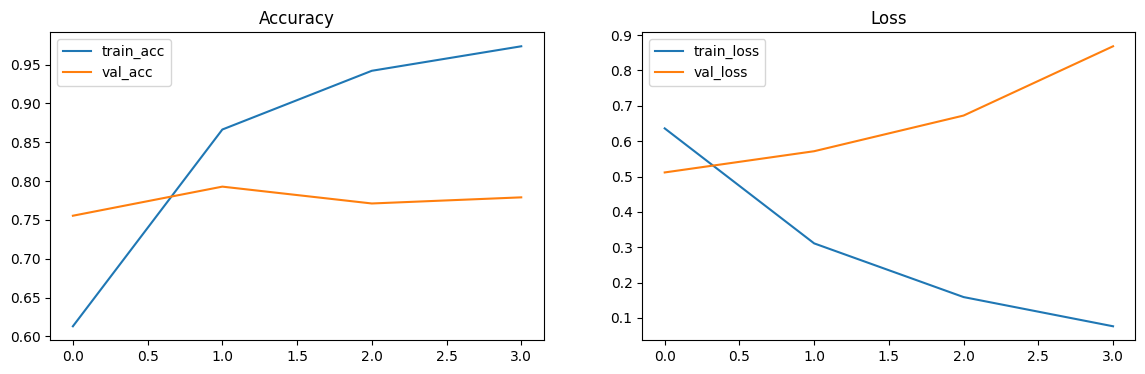

In [8]:
# @title 7. Plot training history
import matplotlib.pyplot as plt

def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(14,4))
    axes[0].plot(history.history['accuracy'], label='train_acc')
    axes[0].plot(history.history['val_accuracy'], label='val_acc')
    axes[0].set_title('Accuracy')
    axes[0].legend()
    axes[1].plot(history.history['loss'], label='train_loss')
    axes[1].plot(history.history['val_loss'], label='val_loss')
    axes[1].set_title('Loss')
    axes[1].legend()
    plt.show()

plot_history(history)


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Accuracy: 0.7845303867403315
Precision: 0.82174688057041
Recall: 0.7271293375394322
F1: 0.7715481171548118

Classification report:
               precision    recall  f1-score   support

           0     0.7550    0.8420    0.7961       633
           1     0.8217    0.7271    0.7715       634

    accuracy                         0.7845      1267
   macro avg     0.7884    0.7846    0.7838      1267
weighted avg     0.7884    0.7845    0.7838      1267



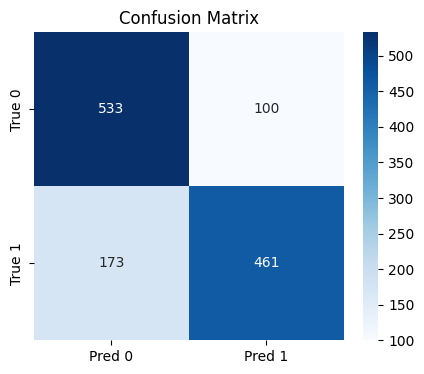

In [9]:
# @title 8. Evaluate on test set
# Load best weights if saved
if os.path.exists('/mnt/data/best_fake_news_model.h5'):
    model.load_weights('/mnt/data/best_fake_news_model.h5')

y_pred_prob = model.predict(X_test_seq, batch_size=128).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, zero_division=0))
print('Recall:', recall_score(y_test, y_pred, zero_division=0))
print('F1:', f1_score(y_test, y_pred, zero_division=0))
print('\nClassification report:\n', classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.title('Confusion Matrix')
plt.show()


In [10]:
# @title 9. Predict single article utility

def predict_text(text: str, threshold: float = 0.5):
    cleaned = clean_text(text)
    seq = texts_to_padded_sequences([cleaned])
    prob = model.predict(seq)[0][0]
    label = int(prob >= threshold)
    return {'probability': float(prob), 'label': label, 'clean_text': cleaned}

# Example
example = 'Example headline: Government announces new policy that will change everything.'
print(predict_text(example))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
{'probability': 0.31173351407051086, 'label': 0, 'clean_text': 'example headline government announces new policy change everything'}


In [12]:
# @title 10. Save model & tokenizer
# Save tokenizer
with open('/mnt/data/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer.to_json())

# Save model (SavedModel format)
model.save('/mnt/data/fake_news_lstm_model.keras') # Added .keras extension
print('Saved tokenizer.json and fake_news_lstm_model under /mnt/data/')


Saved tokenizer.json and fake_news_lstm_model under /mnt/data/


## Next steps & tips

- Try pre-trained embeddings (GloVe) by loading into the Embedding layer weights.
- For best performance on text tasks consider fine-tuning transformer models (BERT / DistilBERT) via HuggingFace.
- If dataset is imbalanced, try class weights or augmentation strategies.

